In [136]:
import qiskit
print(qiskit.__version__)


1.1.0


In [137]:
from qiskit import QuantumCircuit
from qiskit.visualization import circuit_drawer

qc = QuantumCircuit(2)

qc.h(0)
qc.cx(0, 1)

circuit_drawer(qc, output='text')

┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘

In [138]:
from qiskit.quantum_info import Pauli

ZZ = Pauli('ZZ')
ZI = Pauli('ZI')
IZ = Pauli('IZ')
XX = Pauli('XX')
XI = Pauli('XI')
IX = Pauli('IX')

observables = [ZZ, ZI, IZ, XX, XI, IX]

In [139]:
from qiskit.primitives import Estimator

estimator = Estimator()

job = estimator.run([qc] * len(observables), observables)

job.result()

EstimatorResult(values=array([1., 0., 0., 1., 0., 0.]), metadata=[{}, {}, {}, {}, {}, {}])

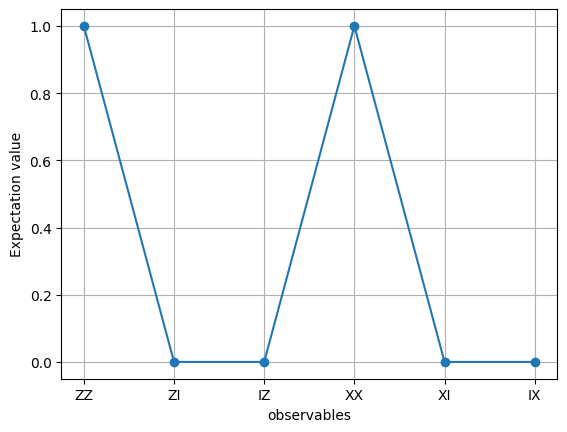

In [140]:
import matplotlib.pyplot as plt

%matplotlib inline

data = ['ZZ','ZI','IZ','XX','XI','IX']
values = job.result().values

plt.plot(data,values, '-o')
plt.xlabel('observables')
plt.ylabel('Expectation value')
plt.grid(True)
plt.show()


In [141]:
def get_qc_for_n_qubit_GHZ_state(n):
    qc = QuantumCircuit(n)
    qc.h(0)
    for i in range(n-1):
        qc.cx(i, i+1)
    return qc
n = 10
qc = get_qc_for_n_qubit_GHZ_state(n)
qc.draw(output='text')

┌───┐                                             
q_0: ┤ H ├──■──────────────────────────────────────────
     └───┘┌─┴─┐                                        
q_1: ─────┤ X ├──■─────────────────────────────────────
          └───┘┌─┴─┐                                   
q_2: ──────────┤ X ├──■────────────────────────────────
               └───┘┌─┴─┐                              
q_3: ───────────────┤ X ├──■───────────────────────────
                    └───┘┌─┴─┐                         
q_4: ────────────────────┤ X ├──■──────────────────────
                         └───┘┌─┴─┐                    
q_5: ─────────────────────────┤ X ├──■─────────────────
                              └───┘┌─┴─┐               
q_6: ──────────────────────────────┤ X ├──■────────────
                                   └───┘┌─┴─┐          
q_7: ───────────────────────────────────┤ X ├──■───────
                                        └───┘┌─┴─┐     
q_8: ────────────────────────────────────────┤ X ├──■──
                                             └───┘┌─┴─┐
q_9: ─────────────────────────────────────────────┤ X ├
                                                  └───┘

In [142]:
from qiskit.quantum_info import SparsePauliOp

operator_strings = ['Z' + 'I' * i + 'Z' + 'I' * (n-2-i) for i in range(n-1)]
print(operator_strings)
print(len(operator_strings))

operators = [SparsePauliOp(operator_string) for operator_string in operator_strings]

['ZZIIIIIIII', 'ZIZIIIIIII', 'ZIIZIIIIII', 'ZIIIZIIIII', 'ZIIIIZIIII', 'ZIIIIIZIII', 'ZIIIIIIZII', 'ZIIIIIIIZI', 'ZIIIIIIIIZ']
9


In [143]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

backend_name = "ibm_brisbane"
backend = QiskitRuntimeService().backend(backend_name)
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)

qc_transpiled = pass_manager.run(qc)
operator_transpiled_list = [op.apply_layout(qc_transpiled.layout) for op in operators]

In [145]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator 
from qiskit_ibm_runtime import EstimatorOptions

options = EstimatorOptions()
options.resilience_level = 1
options.optimization_level = 0
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XY4"

estimator = Estimator(backend, options=options)

job = estimator.run([(qc_transpiled, operator_transpiled_list)])
job_id = job.job_id()
print(job_id)

csv32rvvkv50008ggzk0


In [ ]:
job_id = "csv2entjkdzg0088cyp0"
service = QiskitRuntimeService()
job = service.job(job_id)


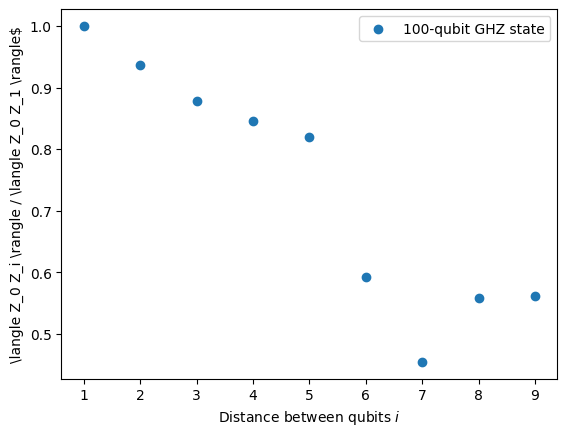

In [146]:
import matplotlib.pyplot as plt

data = list(range(1, len(operators) + 1))
result = job.result()[0]
values = result.data.evs
values = [v / values[0] for v in values]

plt.scatter(data, values, marker = 'o', label = '100-qubit GHZ state')
plt.xlabel('Distance between qubits $i$')
plt.ylabel(r'\langle Z_0 Z_i \rangle / \langle Z_0 Z_1 \rangle$')
plt.legend()
plt.show()

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_quantum", #ibm_cloud
                               token = '0d0ae2ba0d69b07f503c41f9a6f160b3d204e40ff00d7db07963eaae4344d65e7a0013cd77fb8c8dfe5b680c8b7806fc270a44b86bf3a2a2f35ce560a2190a42')
